In [257]:
import torch
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [268]:
class Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return self.softmax(output)

In [269]:
mnist = datasets.MNIST('data/mnist', train=True, download=True)
transform = transforms.ToTensor()
def collate(batch):
    # Convert PIL images to tensors
    batch = [(transform(img), label) for img, label in batch]
    return torch.utils.data.dataloader.default_collate(batch)

def create_dataloader(batch_size):
    return torch.utils.data.DataLoader(mnist, shuffle=True, collate_fn=collate, batch_size=batch_size)

In [270]:
def train(model: nn.Module, epochs=500, lr=0.01, batch_size=128, show_every=100):
    dataloader = create_dataloader(batch_size)

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []

    model.train()
    for epoch in range(epochs):
        opt.zero_grad()

        # Select a batch
        for imgs, lbls in dataloader:
            probs = model(imgs)
            loss = -torch.log(probs[torch.arange(len(lbls)), lbls]).mean()
            break
            
        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        if epoch % show_every == 0:
            print(f"Epoch {epoch}: {loss.item()}")

        # Learning Rate Decay
        if epochs - epoch == int(epochs / 10):
            lr /= 10
            opt = torch.optim.Adam(model.parameters(), lr=lr)
        
    plt.plot(torch.arange(len(losses)), losses)
        

In [271]:
conv = Conv()

Epoch 0: 2.3028769493103027
Epoch 10: 0.7670669555664062
Epoch 20: 0.2781583368778229
Epoch 30: 0.26768040657043457
Epoch 40: 0.17637716233730316
Epoch 50: 0.11211568862199783
Epoch 60: 0.12395398318767548
Epoch 70: 0.1115068644285202
Epoch 80: 0.12194254994392395
Epoch 90: 0.13342390954494476
Epoch 100: 0.0452754944562912
Epoch 110: 0.13477972149848938
Epoch 120: 0.09872280061244965
Epoch 130: 0.05779139697551727
Epoch 140: 0.07025959342718124
Epoch 150: 0.0861944779753685
Epoch 160: 0.033915046602487564
Epoch 170: 0.05500876531004906
Epoch 180: 0.07045777142047882
Epoch 190: 0.033442236483097076


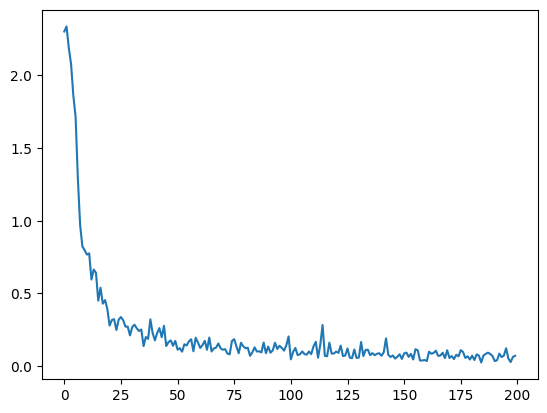

In [272]:
train(conv, epochs=200, lr=0.005, batch_size=256, show_every=10)

In [275]:
# Now want to generate an image that activates a specific neuron, using gradient ascent
# Do this by setting the loss function as the negative of the neuron's activation and optimizing the image as the parameters

def generate_image(model: nn.Module, neuron: int, lr=0.1, epochs=1000):
    img = torch.ones(1, 1, 28, 28, requires_grad=True) # batch_size, num_channels, height, width
    opt = torch.optim.Adam([img], lr=lr)

    losses = []
    for epoch in range(epochs):
        opt.zero_grad()

        additive_noise = torch.randn_like(img, requires_grad=False) * 0.1
        mask_noise = torch.rand_like(img, requires_grad=False) < 0.1
        probs = model(img.masked_fill(mask_noise, 1) + additive_noise)
        loss = -torch.log(probs[0, neuron]) - torch.log(1 - probs[0, torch.arange(10) != neuron]).mean()

        loss.backward()
        opt.step()
        
        losses.append(loss.item())
        if epoch % max(int(epochs / 10), 1) == 0:
            # print(f"Epoch {epoch}: {loss.item()}")
            pass
        
    plt.imshow(img.detach().numpy().squeeze(), cmap='gray')
    plt.show()
        

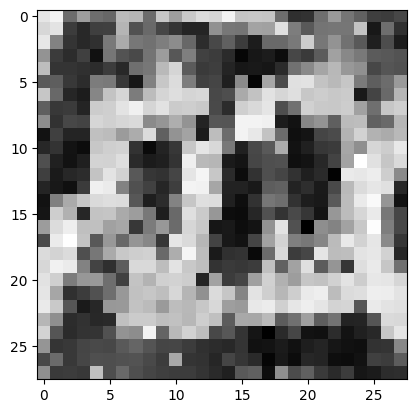

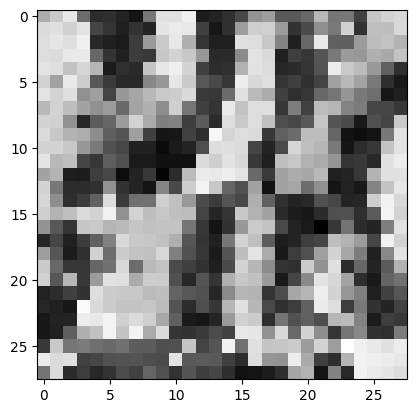

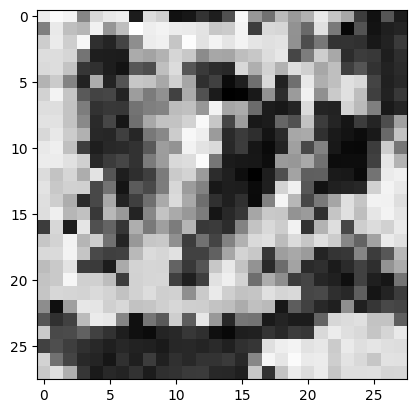

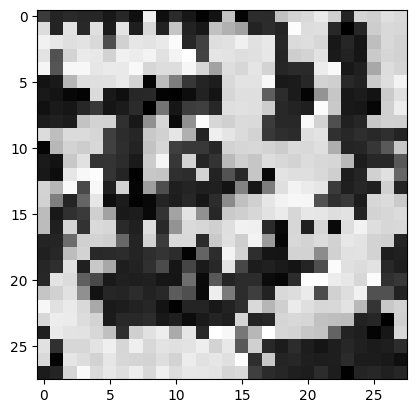

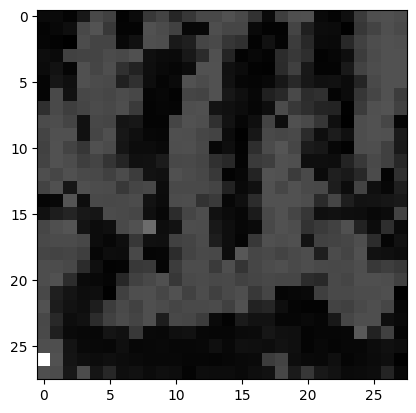

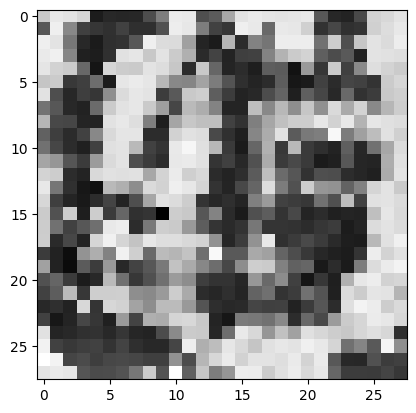

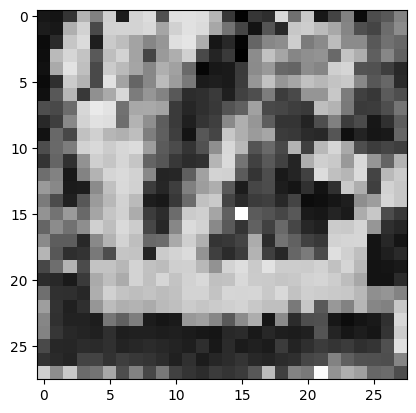

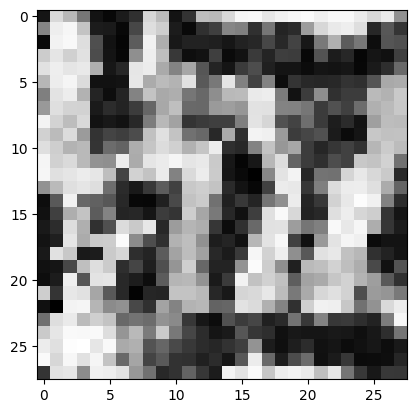

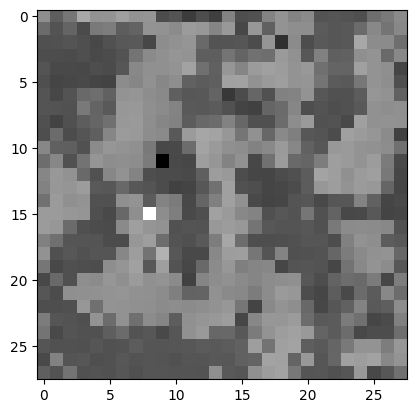

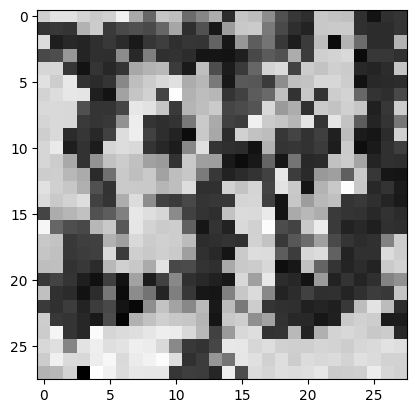

In [276]:
for i in range(10):
    generate_image(conv, i, lr=0.1, epochs=1000)

%matplotlib inline